In [27]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.8/dist-packages/datajoint/connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


In [28]:
# nnfabrik main
from nnvision.tables.legacy.main import MonkeyExperiment
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel, MEIMethod, MEITemplate

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

In [29]:
# parameters

dataset_hash='a737408da40cfedd036c2eb1b8a31ff1'
ensemble_hash='e7a8d0b961ee37ffda0779bfed95f1cf'

data_key='3631807112901'
unit_id = 28
unit_index = 27

# image dimensions:
h, w = 41, 41

data_key: 3631807112901, unit_id = 28, image shape: (41, 41)


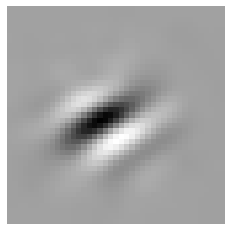

In [30]:
# MEI of our example Neuron
meis = []
for i in range(1, 29):
    mei_path = (MEI_update & dict(dataset_hash=dataset_hash, unit_id=i, data_key=data_key)).fetch1("mei")
    mei = torch.load(mei_path).cpu().numpy().squeeze()
    meis.append(mei)

plt.imshow(mei, cmap="gray")
plt.axis("off");
print(f"data_key: {data_key}, unit_id = {unit_id}, image shape: {mei.shape}")


# Loading the Pretrained Model

In [31]:
model_key = (TrainedModel * TrainedEnsembleModel.Member()&dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
dataloaders, model = TrainedModel().load_model(model_key)

# Preparing a Input to the Network

In [32]:
image = np.ones((h, w))

In [33]:
image = torch.tensor(image).expand(1, 1, h, w).float()
print(image.shape)

torch.Size([1, 1, 41, 41])


# Showing the image to the network

In [34]:
output = model(image, data_key=data_key)
print(output)

tensor([[1.0474, 2.8474, 5.1279, 2.0741, 0.1858, 1.8463, 3.5357, 3.2995, 2.3225,
         1.4257, 1.1249, 2.2426, 1.0805, 1.6501, 0.7194, 0.3462, 2.5356, 1.8475,
         0.8906, 2.2328, 0.7816, 1.2581, 1.5327, 0.6552, 1.7042, 0.1225, 0.0431,
         1.1925, 0.2696]], grad_fn=<AddBackward0>)


In [35]:
output_numpy = output.detach().numpy().squeeze()
print(output_numpy)

[1.0474358  2.8474355  5.1279473  2.0741277  0.18582952 1.8463441
 3.5356617  3.299451   2.3224761  1.4257125  1.1248758  2.2425804
 1.0805346  1.6501459  0.7194471  0.34617746 2.5356102  1.8475382
 0.8905892  2.2328274  0.78164965 1.2580583  1.5327289  0.6551535
 1.7041793  0.12254584 0.04309911 1.1925447  0.2695554 ]


# Get the output of our example Neuron

In [36]:
output_numpy[unit_index]

1.1925447

# Get the Outputs of a large number of images all at once

In [37]:
images = np.random.randn(100, 1, h, w)
images = torch.tensor(images).float()

In [38]:
output = model(images, data_key=data_key).detach().numpy()
print(output.shape)
# so that means, we have 100 responses for the 100 images, for all 29 neurons of this session

(100, 29)


# Plotting the response of the example neuron to all of the 100 random images


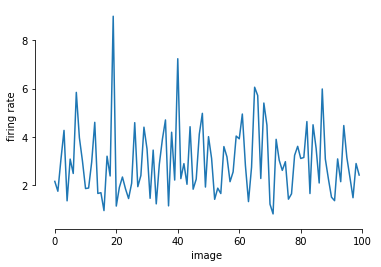

In [48]:
plt.plot(output[:, unit_index])
plt.ylabel("firing rate")
plt.xlabel("image")
sns.despine(trim=True, offset=5)

##### toy insilico experiment done.

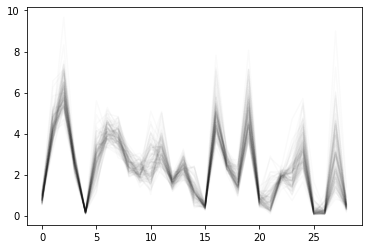

In [50]:
plt.plot(output.T, c='k', alpha=0.02)
plt.show()